## 0 - Libraries

In [ ]:
!pip install transformers timm lightning==2.0.1 --quiet
!sudo apt-get install unzip --quiet
!pip install gdown --quiet
!pip install pandas albumentations --quiet
!pip install matplotlib

Reading package lists...
Building dependency tree...
Reading state information...
unzip is already the newest version (6.0-25ubuntu1.1).
0 upgraded, 0 newly installed, 0 to remove and 28 not upgraded.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 61.8 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 74.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.1/103.1 kB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 88.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.7/301.7 kB 69.2 MB/s eta 0:00:00


In [ ]:
import os
import csv
import timm
import torch
import requests
import itertools
import numpy as np
import pandas as pd
from torch import nn
from PIL import Image
from tqdm.auto import tqdm
import albumentations as A
import torch.nn.functional as F
from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer
import lightning.pytorch as pl
import torch.optim as optim
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.loggers import CSVLogger
import pickle
import matplotlib.pyplot as plt
import multiprocessing
multiprocessing.cpu_count()

16

Download movie posters

In [ ]:
# !gdown 1-1b_eRIQ7bw2tpvC6jgag4moY7FCnMXD
# !unzip posterimages.zip

## 1 - Create Dataset

In [ ]:
class CLIPDataset(torch.utils.data.Dataset):

  def __init__(self,image_filenames, captions, tokenizer, transforms):

    self.image_filenames = image_filenames
    self.captions = list(captions)
    self.encoded_captions  = tokenizer(list(captions), padding = True,
                              truncation=True, max_length = 200)
    self.transform = transforms

  def __len__(self):
    return len(self.captions)

  def __getitem__(self,idx):
    item = {
        key: torch.tensor(values[idx])
        for key, values in self.encoded_captions.items()
    }

    image = np.array(Image.open('/content/' + self.image_filenames[idx]).convert('RGB'))
    image = self.transform(image=image)['image']
    item['image']   = torch.tensor(image).permute(2,0,1).float()
    item['caption'] =  self.captions[idx]
    item['url'] = self.image_filenames[idx]

    return item

def get_transforms(mode="train"):
    if mode == "train":
        return A.Compose(
            [
                A.RandomResizedCrop(224, 224, scale=(0.8, 1.0), ratio=(0.75, 1.33), always_apply=True),
                A.HorizontalFlip(p=0.5),
                A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
                A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, always_apply=False, p=0.5),
                A.CoarseDropout(max_holes=8, max_height=8, max_width=8, min_holes=2, min_height=8, min_width=8, fill_value=0, mask_fill_value=None, always_apply=False, p=0.5),
                A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=True),
            ]
        )
    else:
        return A.Compose(
            [
                A.Resize(224, 224, always_apply=True), # mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225),
                A.Normalize( max_pixel_value=255.0, always_apply=True),
            ]
        )

In [ ]:
# read movie database list
df = pd.read_csv('movie_genre2.csv')
df = df[~df.genre.isnull()]

movie_images_list  = df.images.to_list()
genre_list = df.genre.to_list()

In [ ]:
tokenizer  = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
transforms = get_transforms(mode='train')
movieposter_dataset = CLIPDataset(image_filenames = movie_images_list, captions = genre_list,\
                                  tokenizer=tokenizer,transforms = transforms)
#split - train/val
train_dataset, val_dataset  = torch.utils.data.random_split(movieposter_dataset, [0.9, 0.1])

# dataloader
train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=4,num_workers=8,shuffle=True)
val_dataloader   = torch.utils.data.DataLoader(val_dataset,batch_size=4,num_workers=8,shuffle=False)

In [ ]:
train_dataset[1]

{'input_ids': tensor([ 101, 4516,  102,    0,    0,    0,    0,    0,    0]),
 'attention_mask': tensor([1, 1, 1, 0, 0, 0, 0, 0, 0]),
 'image': tensor([[[-2.0665, -2.1008, -2.1008,  ..., -1.9124, -1.5528, -1.2103],
          [-2.0323, -2.1008, -2.1179,  ..., -2.1179, -2.0837, -1.9980],
          [-2.0152, -2.0837, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1008, -2.1008, -2.1008,  ..., -0.6109, -0.8164, -0.9363],
          [-2.1008, -2.1008, -2.1008,  ..., -0.7137, -0.9363, -1.1075],
          [-2.1008, -2.1008, -2.1008,  ..., -0.9020, -1.1247, -1.2788]],
 
         [[-1.9832, -2.0182, -2.0182,  ..., -1.6506, -1.2129, -0.8452],
          [-1.9132, -1.9832, -2.0182,  ..., -1.9657, -1.8431, -1.6856],
          [-1.9132, -2.0007, -2.0357,  ..., -2.0007, -2.0007, -1.9832],
          ...,
          [-2.0182, -2.0182, -2.0182,  ..., -1.4405, -1.6155, -1.7206],
          [-2.0182, -2.0182, -2.0182,  ..., -1.5455, -1.7206, -1.8431],
          [-2.0182, -2.0182, -2.

In [ ]:
batch = next(iter(train_dataloader))
batch['input_ids'].shape, batch['attention_mask'].shape, batch['image'].shape,batch['caption'],len(batch['url'])

(torch.Size([8, 9]),
 torch.Size([8, 9]),
 torch.Size([8, 3, 224, 224]),
 ['Comedy',
  'Action|Comedy|Crime',
  'Adventure|Drama|Family',
  'Comedy',
  'Drama|Romance',
  'Comedy|Drama',
  'Comedy',
  'Drama|Horror|Thriller'],
 8)

## 2 - Define CLIP Model

In [ ]:
class ImageEncoder(nn.Module):
  def __init__(
      self
  ):
    super().__init__()
    self.model = timm.create_model('resnet50', pretrained = True,
                                   num_classes = 0, global_pool = 'avg')

    for p in self.model.parameters():
      p.requires_grad = True

  def forward(self,x):
    return self.model(x)

class TextEncoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = DistilBertModel.from_pretrained('distilbert-base-uncased')

    for p in self.model.parameters():
      p.requires_grad = True

  def forward(self,input_ids, attention_mask):
    output = self.model(input_ids=input_ids,attention_mask = attention_mask)
    last_hidden_state = output.last_hidden_state
    return last_hidden_state[:,0,:] # CLS TOKEN

class ProjectionHead(nn.Module):
  def __init__(
      self,
      embedding_dim,
      projection_dim = 256,
      dropout = 0.1
  ):
    super().__init__()
    self.projection = nn.Linear(embedding_dim,projection_dim)
    self.gelu       = nn.GELU()
    self.fc         = nn.Linear(projection_dim,projection_dim)
    self.dropout    = nn.Dropout(dropout)
    self.layer_norm = nn.LayerNorm(projection_dim)

  def forward(self,x):
    projected = self.projection(x)
    x = self.gelu(projected)
    x = self.fc(x)
    x = self.dropout(x)
    x = x + projected
    x = self.layer_norm(x)

    return x

In [ ]:
class CLIPModel(nn.Module):
  def __init__(
      self,
      image_embedding = 2048,
      text_embedding  = 768
  ):
    super().__init__()
    self.image_encoder = ImageEncoder()
    self.text_encoder = TextEncoder()

    self.image_projection = ProjectionHead(embedding_dim=image_embedding)
    self.text_projection  = ProjectionHead(embedding_dim=text_embedding)


  def forward(self,batch):
    image_features = self.image_encoder(batch['image'].to('cuda'))
    text_features  = self.text_encoder(
        input_ids  = batch['input_ids'].to('cuda'),attention_mask = batch["attention_mask"].to('cuda')
    )
    image_embeddings = self.image_projection(image_features)
    text_embeddings = self.text_projection(text_features)

    return text_embeddings, image_embeddings

def loss_fn(text_embeddings,image_embeddings,temperature):
    logits = (text_embeddings @ image_embeddings.T) / temperature
    image_similarity = image_embeddings @ image_embeddings.T
    text_similarity  = text_embeddings @ text_embeddings.T

    targets = F.softmax(
        (image_similarity + text_similarity)/(2 * temperature), dim=-1
    )
    texts_loss  = cross_entropy(logits, targets)
    images_loss = cross_entropy(logits.T, targets.T)
    loss = (images_loss + texts_loss) / 2.0
    return loss.mean()

def cross_entropy(preds, targets):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (- targets * log_softmax(preds)).sum(1)
    return loss

In [ ]:
my_clip = CLIPModel()
params = [
        {"params": my_clip.image_encoder.parameters(), "lr": 1e-4},
        {"params": my_clip.text_encoder.parameters(), "lr": 1e-5},
        {"params": itertools.chain(
            my_clip.image_projection.parameters(), my_clip.text_projection.parameters()
        ), "lr": 1e-3, "weight_decay": 1e-3}
    ]

optimizer = torch.optim.AdamW(params, weight_decay=0.)

In [ ]:
# train the model
# epochs = 2
# temperature = 1.0
# my_clip.to('cuda')

# for epoch in range(epochs):

#   my_clip.train()
#   train_loss = 0
#   pbar = tqdm(train_dataloader)
#   for batch_ix,batch_input in enumerate(pbar):
#     text_embeddings, image_embeddings = my_clip(batch_input)
#     loss = loss_fn(text_embeddings, image_embeddings, temperature) #mean loss
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()
#     train_loss += loss
#     pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_ix}')
#   train_loss = train_loss / len(train_dataloader)

#   my_clip.eval()
#   val_loss = 0
#   for batch_ix,batch_input in enumerate(val_dataloader):
#     text_embeddings, image_embeddings = my_clip(batch_input)
#     loss = loss_fn(text_embeddings, image_embeddings, temperature) #mean loss
#     val_loss += loss

#   val_loss = val_loss / len(val_dataloader)

#   print(
#           f"Epoch: {epoch+1} | "
#           f"train_loss: {train_loss:.4f} | "
#           f"test_loss: {val_loss:.4f} | "
#         )

## 4 - Save Model and Image Embeddings for validation set

In [ ]:
#torch.save(my_clip.state_dict(), 'my_clip')

In [ ]:
# get all validation images urls, genre and image embeddings. Need this to build gradio app

val_images_url = []
val_genre      = []
val_image_embeddings = []

total_batches_to_save = 0

for batch_ix,batch_input in enumerate(val_dataloader):
    val_images_url += [u for u in batch_input['url']]
    val_genre  += [g for g in batch_input['caption']]
    _, image_embeddings = my_clip(batch_input)
    val_image_embeddings.append(image_embeddings)

    total_batches_to_save += 1
    if total_batches_to_save >= 100:
        break

In [ ]:
val_image_embeddings_tensor = torch.stack(val_image_embeddings).view(-1,256)
torch.save(val_image_embeddings_tensor, 'val_image_embeddings.pt')

In [ ]:
len(val_genre),len(val_images_url), val_image_embeddings_tensor.shape

(400, 400, torch.Size([400, 256]))

In [ ]:
with open('val_genre.pkl', 'wb') as f:
  pickle.dump(val_genre, f)

with open('val_images_url.pkl', 'wb') as f:
  pickle.dump(val_images_url, f)

## 5 - TEST THE MODEL AND EMBEDDINGS

In [ ]:
my_clip = CLIPModel().to('cuda')
my_clip.load_state_dict(torch.load('my_clip'))
my_clip.eval()

CLIPModel(
  (image_encoder): ImageEncoder(
    (model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act1): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (drop_block): Identity()
          (act2): ReLU(inplace=True)
          (aa): Identity()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1

In [ ]:
# load validation data
file = open("val_genre.pkl",'rb')
genre = pickle.load(file)
file.close()

file = open("val_images_url.pkl",'rb')
poster_url = pickle.load(file)
file.close()

movie_poster_embeddings = torch.load('val_image_embeddings.pt')

In [ ]:
n = 4
query = 'show me something adventurous'
encoded_query = tokenizer([query])
batch = {
        key: torch.tensor(values).to('cuda')
        for key, values in encoded_query.items()
}
text_features   = my_clip.text_encoder(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
text_embeddings = my_clip.text_projection(text_features)

image_embeddings_n = F.normalize(movie_poster_embeddings, p=2,  dim=-1)
text_embeddings_n  = F.normalize(text_embeddings,  p=2,  dim=-1)
dot_similarity = text_embeddings_n @ image_embeddings_n.T
values, indices = torch.topk(dot_similarity.squeeze(0), n)
print(values, indices)

tensor([0.1255, 0.1251, 0.1238, 0.1237], device='cuda:0',
       grad_fn=<TopkBackward0>) tensor([277,  90, 140,  83], device='cuda:0')


User Query>>>>> show me something adventurous
https://images-na.ssl-images-amazon.com/images/M/MV5BMTMyNDg5NjE0N15BMl5BanBnXkFtZTcwMDA4ODQyMQ@@._V1_UY268_CR2,0,182,268_AL_.jpg
https://images-na.ssl-images-amazon.com/images/M/MV5BMTY3NzYzMDMxMl5BMl5BanBnXkFtZTcwOTgxODk0Mw@@._V1_UY268_CR26,0,182,268_AL_.jpg
https://images-na.ssl-images-amazon.com/images/M/MV5BNzg5OTg1NzY3OF5BMl5BanBnXkFtZTgwNDQxNjkwMzE@._V1_UY268_CR4,0,182,268_AL_.jpg
https://images-na.ssl-images-amazon.com/images/M/MV5BYTJmZTVlY2QtYzE3My00MWU4LTg1ZjEtMjllNGFhZWRhODJiL2ltYWdlL2ltYWdlXkEyXkFqcGdeQXVyMjAwODMzNjU@._V1_UY268_CR4,0,182,268_AL_.jpg


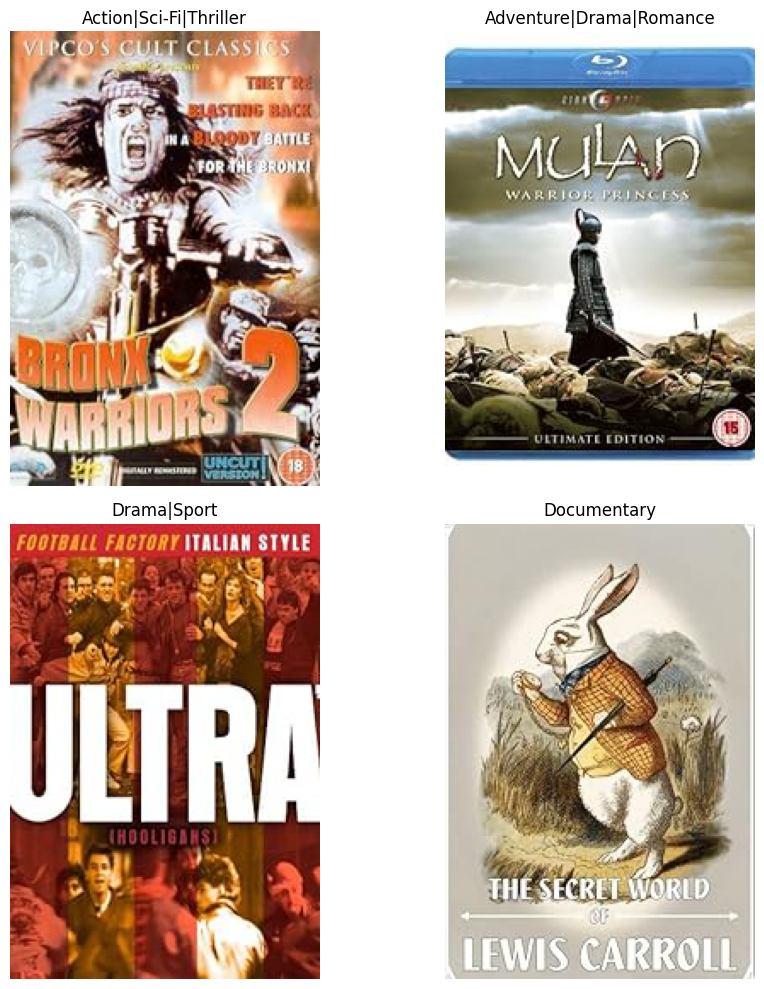

In [ ]:
matches = [val_images_url[idx] for idx in indices]
matches_genre = [val_genre[idx] for idx in indices]
print(f"User Query>>>>> {query}")

_, axes = plt.subplots(2, 2, figsize=(10, 10))

for m, g, ax in zip(matches, matches_genre, axes.flatten()):
  img_https_link = 'https://images-na.ssl-images-amazon.com/images/M/' + m.split('/')[-1]
  image = Image.open(requests.get(img_https_link, stream=True).raw).convert('RGB')
  ax.imshow(image)
  ax.set_title(g)
  ax.axis("off")

plt.tight_layout()
plt.show()

ARCHIVE

In [ ]:
class CLIPLightning(pl.LightningModule):
    def __init__(self, image_embedding=2048, text_embedding=768, temperature=1.0):
        super().__init__()
        self.clip_model = CLIPModel(image_embedding, text_embedding)
        self.temperature = temperature

    def forward(self, batch):
        return self.clip_model(batch)

    def training_step(self, batch, batch_idx):
        text_embeddings, image_embeddings = self(batch)
        loss = loss_fn(text_embeddings, image_embeddings, self.temperature)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        text_embeddings, image_embeddings = self(batch)
        loss = loss_fn(text_embeddings, image_embeddings, self.temperature)
        self.log('val_loss', loss)
        return loss

    def training_epoch_end(self,outputs):
        loss = torch.stack([x['loss'] for x in outputs]).mean()

        print("****Training****")
        print(f'Epoch {self.current_epoch}: Train loss {loss}')

    def validation_epoch_end(self,outputs):
          loss = torch.stack([x for x in outputs]).mean()

          print("****Validation****")
          print(f'Epoch {self.current_epoch}: Validation loss {loss}')

    def configure_optimizers(self):
        params = [
            {"params": self.clip_model.image_encoder.parameters(), "lr": 1e-4},
            {"params": self.clip_model.text_encoder.parameters(), "lr": 1e-5},
            {"params": itertools.chain(
                self.clip_model.image_projection.parameters(), self.clip_model.text_projection.parameters()
            ), "lr": 1e-3, "weight_decay": 1e-3}
        ]
        optimizer = torch.optim.AdamW(params, weight_decay=0.)
        return optimizer

In [ ]:
pl.seed_everything(1234)
my_clip = CLIPLightning().to('cuda')

trainer = pl.Trainer(accelerator='gpu', devices=1, max_epochs=2, logger= [CSVLogger(save_dir="logs/")],
                    callbacks=[LearningRateMonitor(logging_interval="step")])
trainer.fit(my_clip,train_dataloader ,val_dataloader)